In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
ax = rc("font", family="serif", size=11)

We shall create an oscillating signal with an exponentially decaying component, which will then have some Gaussian noise applied to it. This can be represented using the following equation

$$ y\left(t\right) = \alpha\sin\left(\omega t + \phi\right)e^{-2\beta t} $$

We shall choose some initial values of $\alpha=10$, $\beta=0.1$; with a angular frequency of $\omega = \frac{20}{2\pi}$.

The phase shift $\phi$ is defined as being some random number $-\pi<\phi\leq\pi$ that is applied to the sinusoidal waveform.

In [172]:
N_smooth = 360
N = 360
C = 1      # Defines length of data in integers of 2*pi
alpha = 10
beta = 0.5
phi = 2*np.pi*np.random.random(1)-np.pi
#phi = 0.5*np.pi
#phi = -2.59929972
print(phi)

t = np.linspace(0, np.pi*C, N)
t_smooth = np.linspace(0, np.pi*C, N_smooth)
frequency = 3
omega = frequency*2*np.pi
print(omega)


def sine(t,alpha,omega,phi):
    return alpha*np.sin(omega*t+phi)
def expn(t,beta):
    return np.exp(-2 * beta * t)

decay = sine(t,alpha,omega,phi) * expn(t,beta)

f_sg = 1
f_true = np.random.randn(N) * f_sg + decay
f_obs_sg = np.ones(N) * 1
f_obs = f_true + np.random.randn(N) * f_obs_sg

[-2.51836314]
18.84955592153876


With the noise added to our data, let's plot it to see its effect and see what we will be aiming to make inferences from. 

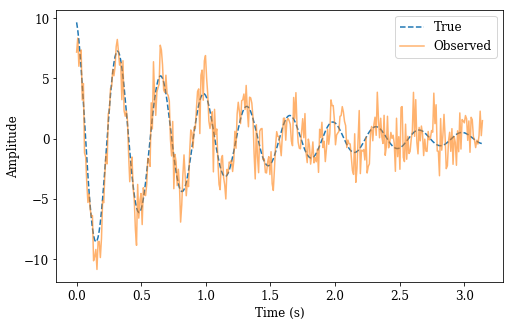

In [155]:
plt.figure(1, figsize=(8,5))
plt.plot(t, decay, '--', label=('True'))
plt.plot(t, f_obs, alpha=0.6, label=('Observed'))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Now let's introduce and implement our Stan code.

In [187]:
code = '''
functions {
    real sine(real omega, real alpha, real t, real phi){
        return alpha * sin(omega*t+phi);
    }
    real expn(real t, real beta){
        return exp(-2 * beta * t);
    }
}
data {
    int N;
    real t[N];
    real f[N];
    real f_unc[N];
}
parameters {
    real<lower = 0> omega;
    real<lower = 0> beta;
    real phi;
    real ln_height;

}
transformed parameters {
    real height;
    real freq;
    height = exp(ln_height);
    freq = omega/(2 * pi());
}
model {

    real mod[N];
    for (i in 1:N){
        mod[i] = sine(omega, height, t[i], phi) * expn(t[i], beta);
    }
    mod ~ normal(f,f_unc);
    freq ~ normal(3, 0.1);
    height ~ normal(10.0, 0.3);
    beta ~ normal(0.5, 0.1);
    phi ~ normal(0, 1.5);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_313fbdff274c81d8419c0af027f8c888 NOW.


In [188]:
stan_data = {'N': len(t),
             't': t, 
             'f': f_obs,
             'f_unc': f_obs_sg}
# start = {'omega': 19}
# start = {'phi': 0}
nchains = 4
fit = sm.sampling(data=stan_data, iter=1000, chains=nchains, init=[start for n in range(nchains)])

In [189]:
print(fit)

Inference for Stan model: anon_model_313fbdff274c81d8419c0af027f8c888.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
omega      18.92  9.7e-4   0.04  18.84  18.89  18.91  18.94  18.99   1569    1.0
beta        0.49  5.3e-4   0.02   0.46   0.48   0.49    0.5   0.52    981    1.0
phi        -0.98    1.92   2.72   -2.6  -2.56  -2.54   0.91   3.77      2 104.51
ln_height    2.3  5.9e-4   0.02   2.27   2.29    2.3   2.32   2.34   1046    1.0
height     10.02  5.9e-3   0.19   9.64   9.89  10.01  10.16   10.4   1048    1.0
freq        3.01  1.5e-4 6.1e-3    3.0   3.01   3.01   3.01   3.02   1569    1.0
lp__      -366.4    0.49   1.55 -370.1 -367.3 -366.2 -365.2 -364.3     10   1.14

Samples were drawn using NUTS at Sun Nov 25 21:31:09 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale re

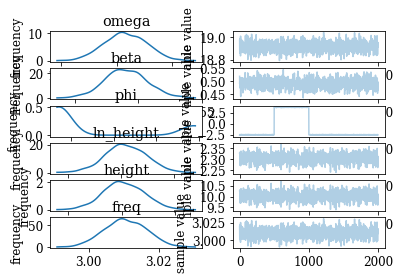

In [190]:
#%matplotlib tk
fit.plot()
plt.show()

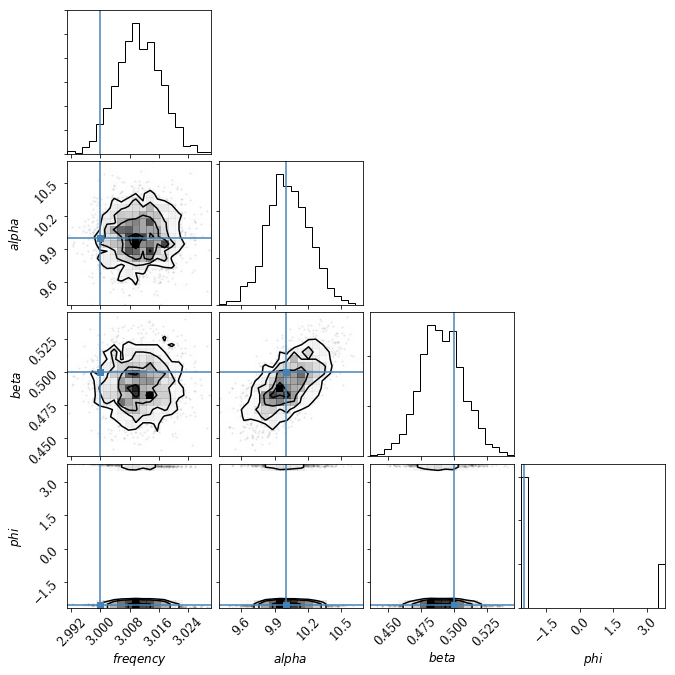

In [191]:
%matplotlib inline
import corner
rc("font", family="serif", size=12)
data = np.vstack([fit['freq'], np.exp(fit['ln_height']), fit['beta'], fit['phi']]).T
corner.corner(data, labels=[r'$freqency$', r'$alpha$', r'$beta$', r'$phi$'], truths=[frequency, alpha, beta, phi])
plt.show()

### Comments on model failure

As we can see from the corner plot, the model has converged very well for the values of alpha, beta and omega, however the distribution in phi is clearly bimodal. The model always seems to converge correctly if the initial function has a phase shift very close to intervals of $\frac{\pi}{4}$ (ie looks like $\pm\sin$ or $\pm\cos$).

At intermediate values of $\phi$ however, the model seems completely inconsistent with regards to whether it converges correctly for the phase. Indeed, running the fit multiple times for the current phase of $\phi = -2.59929972$ seems to usually cause the bimodal peak, however occasionally it works first time.

The plot below shows the issue with this, since the mean value of the array is no longer representative of the most likely parameter values. This results in the model being in antiphase to the data.

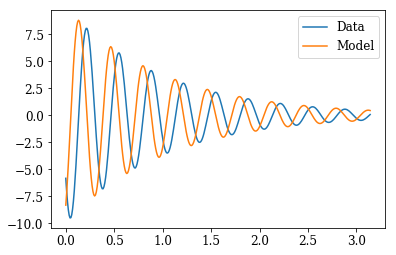

In [193]:
plt.plot(t, decay, label='Data')
plt.plot(t_smooth, sine(t_smooth, np.exp(fit['ln_height'].mean()), fit['omega'].mean(),
                 np.mean(fit['phi'])) * expn(t_smooth, fit['beta'].mean()), label='Model')
plt.legend()

It is clear to me the reason why it is flicking between two values, since they produce the same value in the sine function, in the same way that $\sin\left(\frac{3\pi}{4}\right) = \sin\left(-\frac{\pi}{4}\right)$. This is very roughly demonstrated in the plot below, taking the max and min estimated values for phi, and showing they represent the same function.

I tried to fix this issue by adding some limits in the stan code ```real <lower = -3.1416, upper = 3.1416> phi``` however this made the model worse when I ran it, with omega additionally becoming bimodal. (I've uncommented that line from the stan code, but feel free to re-run with it to see what I mean).


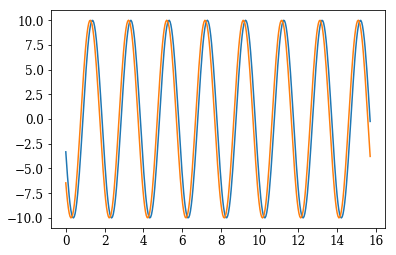

In [80]:
plt.plot(t, sine(t,10,3.18,min(fit['phi'])))
plt.plot(t, sine(t,10,3.18,max(fit['phi'])))

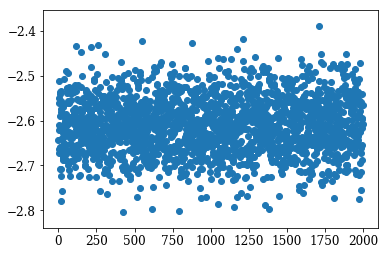

In [50]:
plt.scatter(np.arange(0,len(fit['phi']),1),fit['phi'])